# Introduction to Deep Learning, Assignment 2, Task 2

# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*

When using the Lab Computers, download the Jupyter Notebook to one of the machines first.

If you want to use Google Colab, you should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import os
import glob
import keras


print("GPUs:", tf.config.list_physical_devices('GPU'))

2025-12-08 14:14:04.564990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 14:14:08.585479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-08 14:14:09.942575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-08 14:14:10.166622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-08 14:14:13.031967: I tensorflow/core/platform/cpu_feature_guar

GPUs: []


I0000 00:00:1765199746.707847   31683 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-08 14:15:51.721152: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


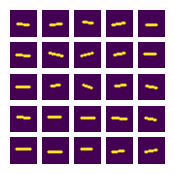

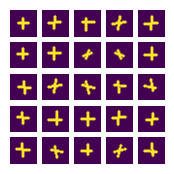

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


## Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #7753

X_text: "38-76" = y_text: "-38"


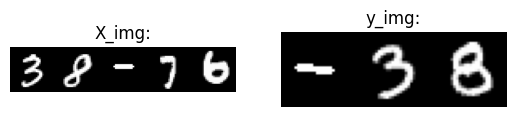

Query #6323

X_text: "31-61" = y_text: "-30"


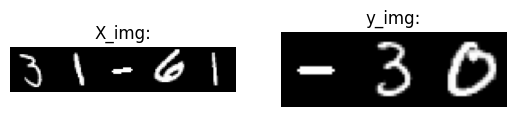

Query #5544

X_text: "27+72" = y_text: "99 "


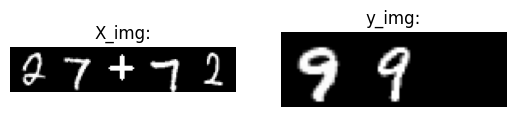

Query #5096

X_text: "25+48" = y_text: "73 "


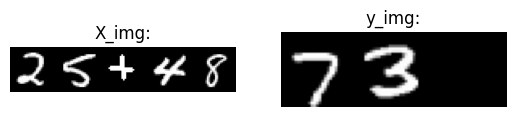

Query #180

X_text: "0+90 " = y_text: "90 "


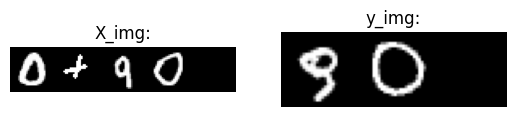

Query #6529

X_text: "32-64" = y_text: "-32"


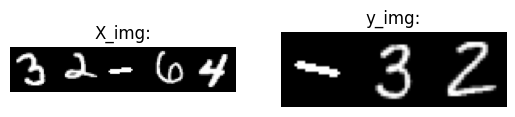

Query #2020

X_text: "10+10" = y_text: "20 "


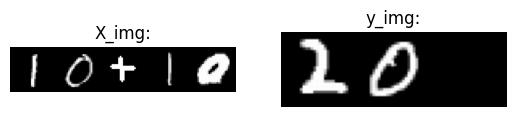

Query #9951

X_text: "49-75" = y_text: "-26"


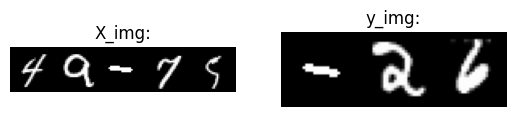

Query #326

X_text: "1+63 " = y_text: "64 "


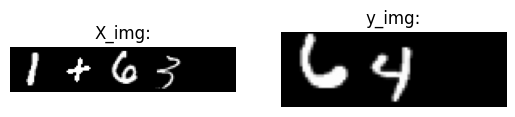

Query #7159

X_text: "35-79" = y_text: "-44"


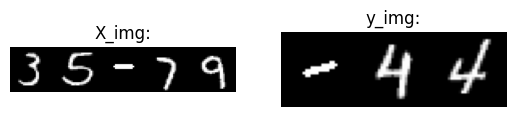

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=2)
    predicted = [''.join([unique_characters[i] for i in j]) for j in pred]

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [6]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # text2text.summary()

    return text2text

### Splitting the data function

In [7]:
def shuffle_in_unison(a,b):
    if len(a) != len(b): raise ValueError('Arrays are not the same lenght.')
        
    indices = list(range(0,len(a)))
    np.random.shuffle(indices)
    a_shuffled = [a[i] for i in indices]
    b_shuffled = [b[i] for i in indices]
    return a_shuffled, b_shuffled

def split_and_randomize(input,output,train_split_size=0.5):
    input, output = shuffle_in_unison(input,output)
    split_index = int(train_split_size*len(input))
    train_input, test_input = np.array(input[:split_index]), np.array(input[split_index:])
    train_output, test_output = np.array(output[:split_index]), np.array(output[split_index:])
    return train_input, train_output, test_input, test_output

### controlling the data split 

In [8]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## (Your first task is to fit the text2text model using X_text and y_text)

#this code will overwrite models and will use this list as an indicator of how many models to load
train_fractions = [0.5,0.25,0.1]
text_data = {}
image_data={}

for train_fraction in train_fractions:
    text_train_x, text_train_y, text_test_x, text_test_y = split_and_randomize(X_text_onehot, y_text_onehot, train_split_size=train_fraction)
    image_train_x, image_train_y, image_test_x, image_test_y = split_and_randomize(X_img, y_img, train_split_size=train_fraction)
    text_data[str(train_fraction)] = {'train_x':text_train_x,'train_y':text_train_y,'test_x':text_test_x,'test_y':text_test_y}
    image_data[str(train_fraction)] = {'train_x':image_train_x,'train_y':image_train_y,'test_x':image_test_x,'test_y':image_test_y}


## Creating and loading models

In [ ]:

models_data_and_predictions = {}
train_new_models = False

epochs = 400
batch_size = 128
valid_split = 0.1
early_stop_patience = 40
early_stop_start = 20

if train_new_models == True:

    # house keeping
    model_files = glob.glob('./models/*')
    for f in model_files:
        print(f'Removing {f} from ./models/')
        os.remove(f)
    history_files = glob.glob('./histories/*')
    for f in history_files:
        print(f'Removing {f} from ./histories/')
        os.remove(f)

    for model_num in range(1, len(train_fractions) + 1):
        t2tmodel = build_text2text_model()
        
        fraction_key = str(train_fractions[model_num-1])
        train_x = text_data[fraction_key]['train_x']
        train_y = text_data[fraction_key]['train_y']
        test_x = text_data[fraction_key]['test_x']
        test_y = text_data[fraction_key]['test_y']

        history = t2tmodel.fit(x=train_x,
                               y=train_y,
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_split=valid_split,
                               callbacks=[EarlyStopping(monitor='val_accuracy',
                                                        patience=early_stop_patience,
                                                        start_from_epoch=early_stop_start,
                                                        restore_best_weights=True)])

        model_name = f'model_{model_num}'

        t2tmodel.save(f'./models/{model_name}.keras')
        with open(f'./histories/{model_name}_history', 'wb') as file:
            pickle.dump(history.history, file)

        t2t_pred = t2tmodel.predict(test_x)

        models_data_and_predictions[model_name] = {'model': t2tmodel,
                                                   'inputs': test_x,
                                                   'predictions': t2t_pred,
                                                   'true_values': test_y,
                                                   'history': history.history}


else:
    for model_num in range(1, len(train_fractions) + 1):
        model_name = f'model_{model_num}'
        
        fraction_key = str(train_fractions[model_num-1])
        train_x = text_data[fraction_key]['train_x']
        train_y = text_data[fraction_key]['train_y']
        test_x = text_data[fraction_key]['test_x']
        test_y = text_data[fraction_key]['test_y']

        t2tmodel = keras.models.load_model(f'./models/{model_name}.keras')
        with open(f'./histories/{model_name}_history', 'rb') as file:
            history = pickle.load(file)

        t2t_pred = t2tmodel.predict(test_x)

        models_data_and_predictions[model_name] = {'model': t2tmodel,
                                                   'inputs': test_x,
                                                   'predictions': t2t_pred,
                                                   'true_values': test_y,
                                                   'history': history}

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


## Visualizing history and accuracy

In [66]:

blues = plt.cm.Blues(np.linspace(0.4, 0.9, 4))  # 5 blues
reds = plt.cm.Reds(np.linspace(0.4, 0.9, 4))  # 5 reds


def plot_all_history(all_model_dict, title='All Losses', plot_name='All_Losses'):
    fig, ax = plt.subplots()
    color_num = 0
    for model_num, model_info in all_model_dict.items():
        color_num += 1
        history = model_info['history']
        loss = history['loss']
        val_loss = history['val_loss']
        ax.plot(loss,
                linestyle='-',
                linewidth=2,
                color=blues[color_num],
                label=f'Training loss {model_num}')
        ax.plot(val_loss,
                linestyle='--',
                linewidth=2,
                color=reds[color_num],
                label=f'Validation loss {model_num}')
    ax.set_xlabel = 'Epochs'
    ax.set_ylabel = 'Loss'
    ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    fig.savefig(f'./plots/{plot_name}.eps', format='eps')
    plt.show()


def plot_all_accuracy(all_model_dict, title='All Accuracys', plot_name='All_Accuracys'):
    fig, ax = plt.subplots()
    color_num = 0
    for model_num, model_info in all_model_dict.items():
        color_num += 1
        history = model_info['history']
        accuracy = history['accuracy']
        val_accuracy = history['val_accuracy']
        ax.plot(accuracy,
                linestyle='-',
                linewidth=2,
                color=blues[color_num],
                label=f'Training accuracy {model_num}')
        ax.plot(val_accuracy,
                linestyle='--',
                linewidth=2,
                color=reds[color_num],
                label=f'Validation accuracy {model_num}')
    ax.set_xlabel = 'Epochs'
    ax.set_ylabel = 'Accuracy'
    ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    fig.savefig(f'./plots/{plot_name}.eps', format='eps')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


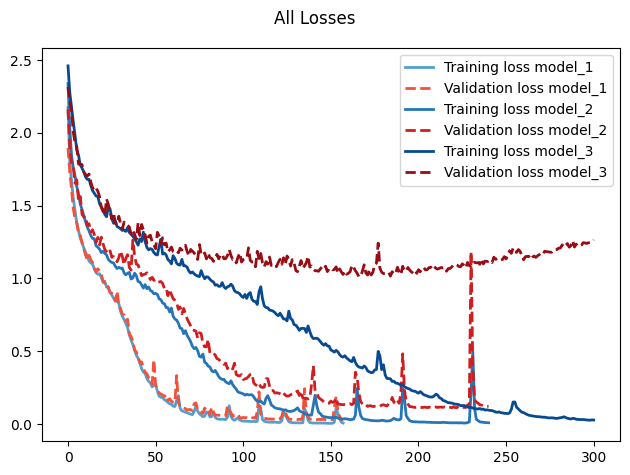

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


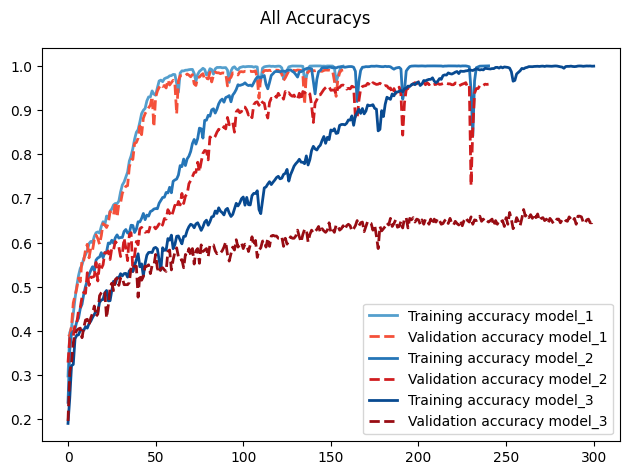

In [67]:
plot_all_history(models_data_and_predictions)
plot_all_accuracy(models_data_and_predictions)

## Visualizing error

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
def plot_hist_predictions(all_model_dict):

    savedir = f'./plots/hist_predictions_for_i2t_model.eps'

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
    axes = np.array([axes])
    axes = axes.flatten()
    fig.suptitle('Visuallizing the error of the t2t models')

    for idx, (model_num, model_info) in enumerate(all_model_dict.items()):
        
        predictions_decoded = decode_labels(model_info['predictions'])
        for i, prediction in enumerate(predictions_decoded):
            try:
                predictions_decoded[i] = int(prediction)
            except ValueError:
                predictions_decoded[i] = np.nan
        predictions = np.array(predictions_decoded,dtype=float)
        true_values = np.array(decode_labels(model_info['true_values']),dtype=int)
        
        mask = ~np.isnan(true_values) & ~np.isnan(predictions)

        mae = mean_absolute_error(true_values[mask], predictions[mask])
        mse = mean_squared_error(true_values[mask], predictions[mask])
        r2 = r2_score(true_values[mask], predictions[mask])

        h = axes[idx].hist2d(true_values[mask], predictions[mask], bins=298, density=False, cmap='jet')
        fig.colorbar(h[3], ax=axes[idx])

        axes[idx].plot([-99, 198], [-99, 198], 'k--',lw=1, label='Perfect Prediction')
        axes[idx].set_title(f'MAE={mae:.2f}, MSE={mse:.2f}, R2={r2:.3f}')
        axes[idx].set_xlabel('Actual sum')
        axes[idx].set_ylabel('Predicted sum')
        axes[idx].legend()

    plt.savefig(savedir, format='eps')
    plt.show()

def plot_scatter_predictions(all_model_dict):

    savedir = f'./plots/scatter_predictions_for_i2t_model.eps'

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
    axes = np.array([axes])
    axes = axes.flatten()
    fig.suptitle('Visuallizing the error of the t2t models')

    for idx, (model_num, model_info) in enumerate(all_model_dict.items()):
        nan_counter = 0 
        predictions_decoded = decode_labels(model_info['predictions'])
        for i, prediction in enumerate(predictions_decoded):
            try:
                predictions_decoded[i] = int(prediction)
            except ValueError:
                predictions_decoded[i] = np.nan
                nan_counter+=1
        predictions = np.array(predictions_decoded,dtype=float)
        true_values = np.array(decode_labels(model_info['true_values']),dtype=int)
        
        mask = ~np.isnan(true_values) & ~np.isnan(predictions)

        mae = mean_absolute_error(true_values[mask], predictions[mask])
        mse = mean_squared_error(true_values[mask], predictions[mask])
        r2 = r2_score(true_values[mask], predictions[mask])

        h = axes[idx].scatter(true_values, predictions)
        
        axes[idx].set_yticks(range(-200,1001,100))
        axes[idx].set_ylim(-201,1001)
        axes[idx].plot([-99, 198], [-99, 198], 'k--',lw=1, label='Perfect Prediction')
        axes[idx].set_title(f'MAE={mae:.2f}, MSE={mse:.2f}, R2={r2:.3f}\nNumber of Nan values={nan_counter}')
        axes[idx].set_xlabel('Actual Sum')
        axes[idx].set_ylabel('Predicted Sum')
        axes[idx].legend()
        axes[idx].grid(axis='x')

    plt.savefig(savedir, format='eps')
    plt.show()

def show_nan_table(all_model_dict):
    savedir = f'./plots/table_nan_i2t.eps'

    col_template=['input','output','true value']
    columns = []
    all_models=[]
    rows=[]
    for idx, (model_num, model_info) in enumerate(all_model_dict.items()):
        columns += col_template
    
        nan_counter = 0 
        junk =[]
        nan = []
        predictions_decoded = decode_labels(model_info['predictions'])
        for i, prediction in enumerate(predictions_decoded):
            try:
                junk.append(int(prediction))
            except ValueError:
                nan_counter +=1
                input = decode_labels(model_info['inputs'])
                true = decode_labels(model_info['true_values'])
                nan.append([input[i],prediction,true[i]])
        all_models.append(nan)
    print(all_models)
    max_rows = max(len(m) for m in all_models)
    
    for r in range(max_rows):
        row = []
        for model_rows in all_models:
            if r < len(model_rows):
                row.extend(model_rows[r])
            else:
                row.extend(["", "", ""])
        rows.append(row)

    df = pd.DataFrame(rows, columns=columns)

    fig, ax = plt.subplots(figsize=(12, 5))

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc="center"
    )

    table.scale(1.2, 1.6)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    ax.axis("off")

    plt.savefig(savedir, format='eps', bbox_inches="tight")
    plt.show()

def show_nan_hist(all_models_dict):
    savedir = f'./plots/hist_nan_i2t.eps'

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
    axes = np.array([axes])
    axes = axes.flatten()
    fig.suptitle('Failure to predict t2t models \nPredicted value of \'-  \'')
    bins = list(range(-20,22))
    bins = [b - 0.5 for b in bins]

    for idx, (model_num, model_info) in enumerate(all_models_dict.items()):
        junk = []
        nan = []
        nan_counter=0
        predictions_decoded = decode_labels(model_info['predictions'])
        true = decode_labels(model_info['true_values'])
        for i, prediction in enumerate(predictions_decoded):
            try:
                junk.append(int(prediction))
            except ValueError:
                nan_counter+=1
                nan.append(int(true[i]))
        axes[idx].hist(nan, bins=bins, range = (-20,20))

        axes[idx].set_xticks(range(-20,21,4))
        axes[idx].set_yticks(range(0,20,2))
        axes[idx].set_title(f'Number of Nan values={nan_counter}')
        axes[idx].set_xlabel('Failed prediction value')
        axes[idx].set_ylabel('Counts')
        axes[idx].legend()

    plt.savefig(savedir, format='eps')
    plt.show()
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


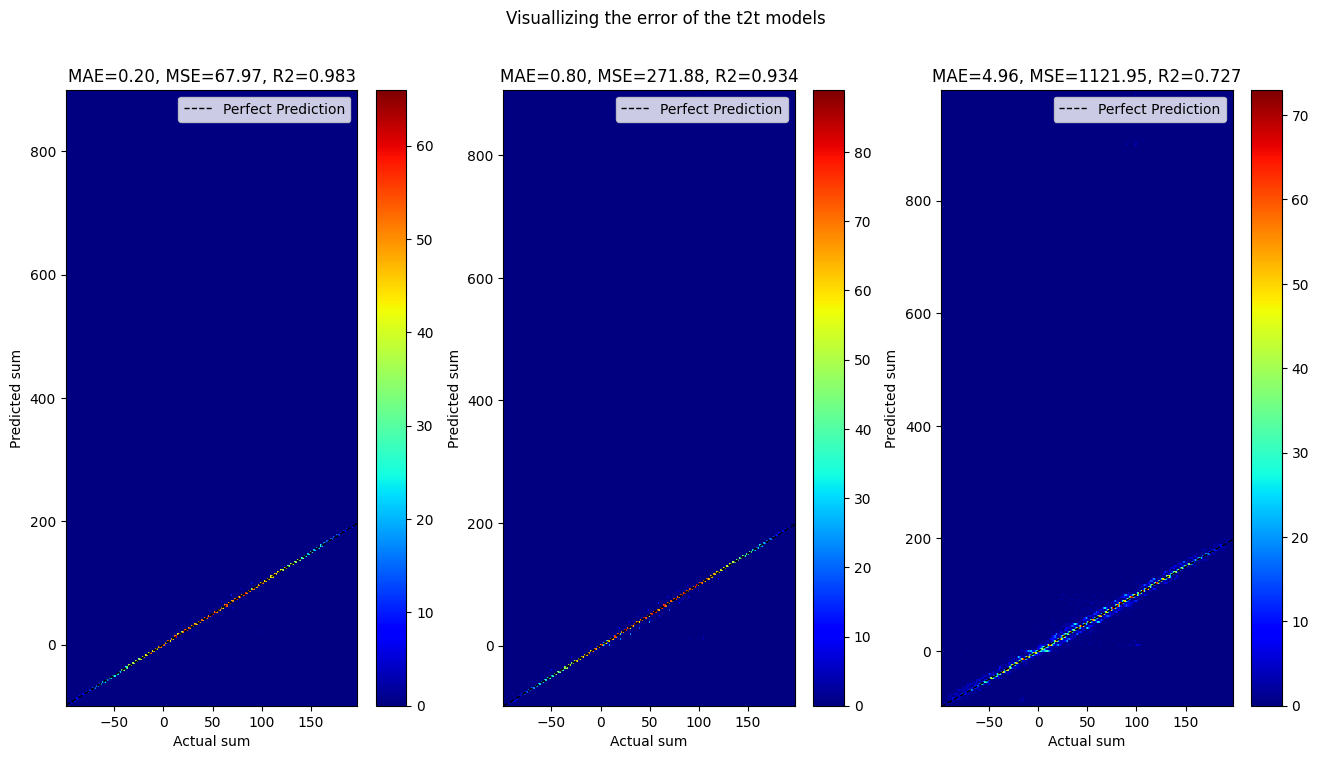

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


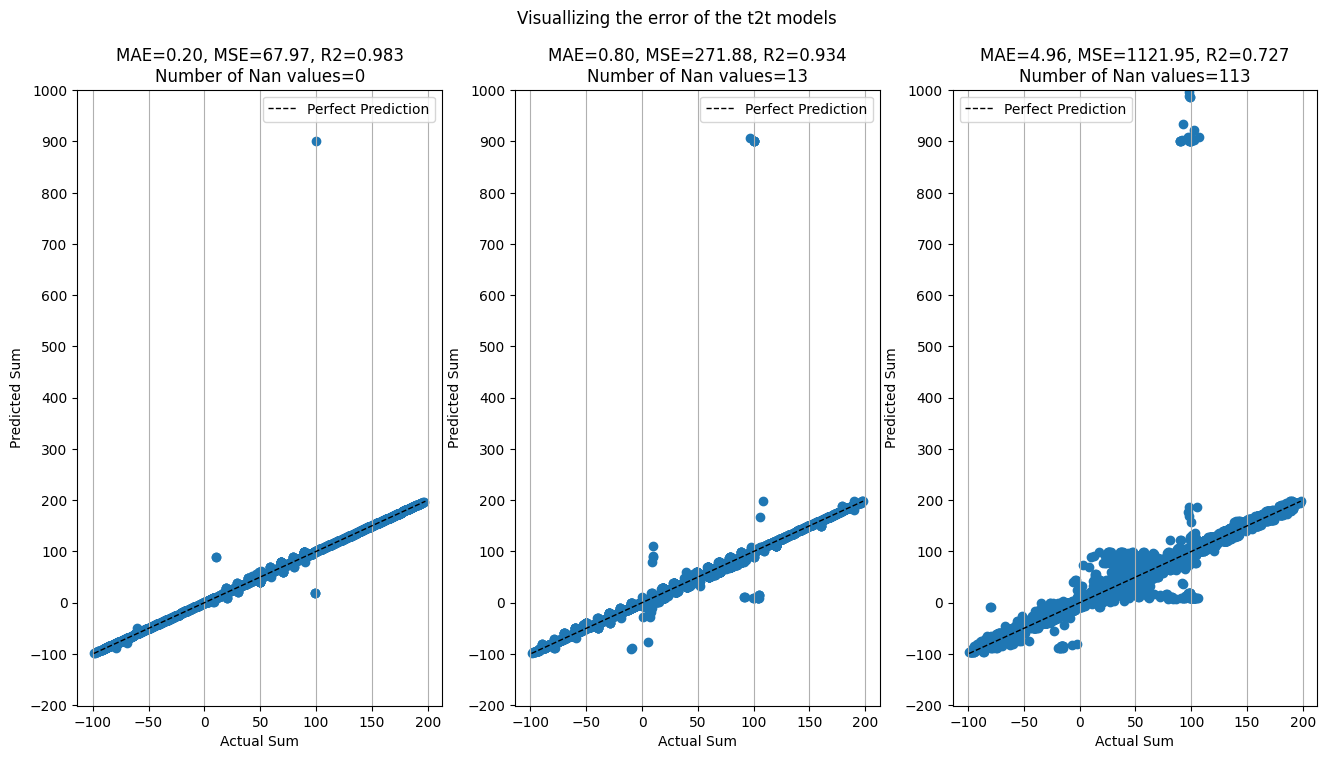

/tmp/ipykernel_2635051/1110615975.py:161: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx].legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


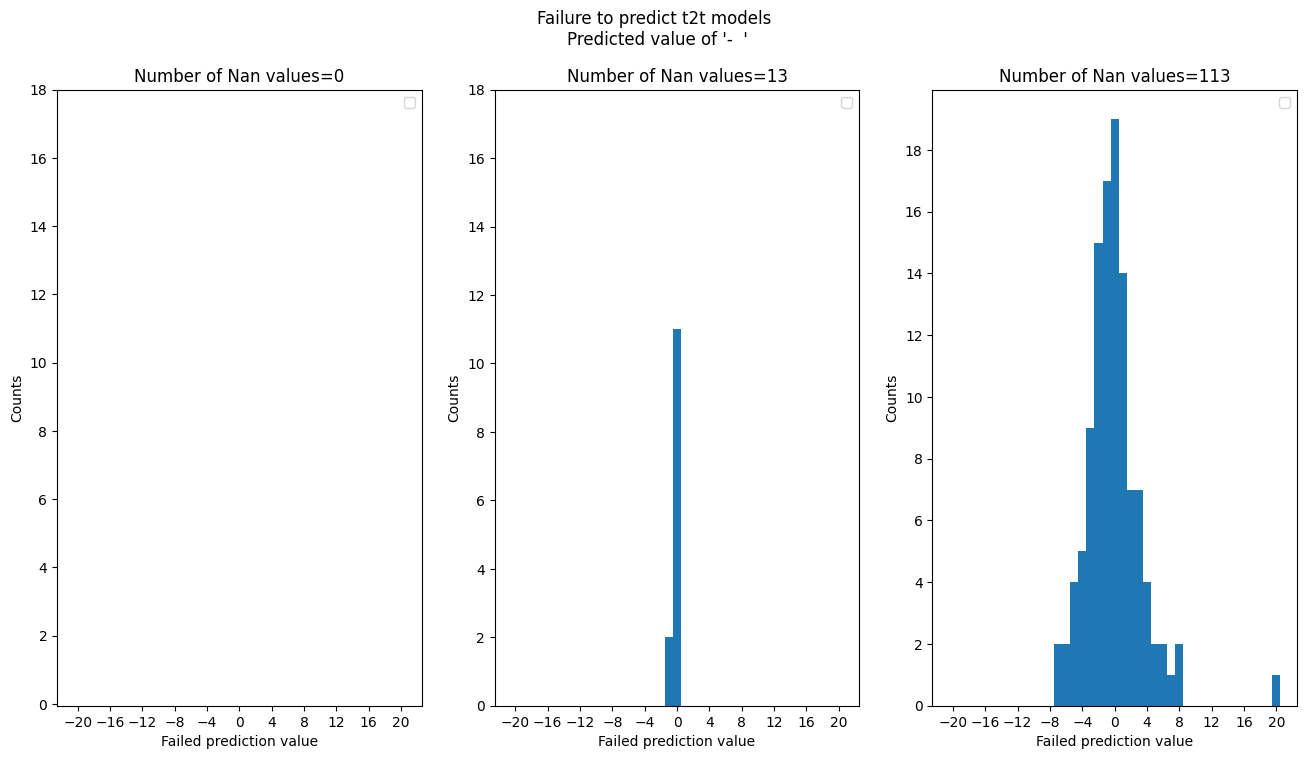

In [69]:
plot_hist_predictions(models_data_and_predictions)
plot_scatter_predictions(models_data_and_predictions)
# show_nan_table(models_data_and_predictions)
show_nan_hist(models_data_and_predictions)


## 

## Text to Text Ivan

In [ ]:
## Your code
tf.keras.utils.set_random_seed(67)
#percentage of X to y:
scores={}
for percentage in [5, 10, 15, 25, 50, 75, 90, 99]:
  print(f"Training with {percentage}% of data")

  X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=percentage/100, random_state=67)

  text2text = build_text2text_model()
  text2text.fit(X_train, y_train, epochs=15, verbose=0)
  results = text2text.evaluate(X_test, y_test, verbose=0)
  print("Test loss, Test accuracy:", results)



  # Split test set into add and subtraction groups
  add_indices = []
  sub_indices = []
  for i in range(min(1000,len(X_test))):
      q_str = decode_labels(X_test[i:i+1])[0]
      if "+" in q_str:
          add_indices.append(i)
      if "-" in q_str:
          sub_indices.append(i)

  # Balance sample count
  n_samples = min(len(add_indices), len(sub_indices), 100)  
  add_indices = np.random.choice(add_indices, n_samples, replace=False)
  sub_indices = np.random.choice(sub_indices, n_samples, replace=False)

  # Accuracy calculations
  add_correct = 0
  sub_correct = 0

  for idx in add_indices:
      pred = text2text.predict(X_test[idx:idx+1], verbose=0)
      if decode_labels(pred)[0] == decode_labels(y_test[idx:idx+1])[0]:
          add_correct += 1

  for idx in sub_indices:
      pred = text2text.predict(X_test[idx:idx+1], verbose=0)
      if decode_labels(pred)[0] == decode_labels(y_test[idx:idx+1])[0]:
          sub_correct += 1

  add_acc = add_correct / n_samples
  sub_acc = sub_correct / n_samples

  print(f"Addition accuracy:{add_acc:.3f}")
  print(f"Subtraction accuracy:{sub_acc:.3f}")

  scores[percentage] = {
      "overall_loss": results[0],
      "overall_acc": results[1],
      "add_acc": add_acc,
      "sub_acc": sub_acc,
    }
  # Draw 10 random queries to display
  for _ in range(15):
      query_n = np.random.randint(0, len(X_test))
      query = X_test[query_n:query_n+1]

      prediction = text2text.predict(query, verbose=0)

      print("----------------------------------------")
      print(f"Quesion: {decode_labels(query)}")
      print(f"Pred: {decode_labels(prediction)}")
      print(f"Actual: {decode_labels(y_test[query_n:query_n+1])}")
 #scores.update({percentage: results})



In [ ]:
import matplotlib.pyplot as plt

percentages = list(scores.keys())
overall_acc = [scores[p]["overall_acc"] for p in percentages]
add_acc = [scores[p]["add_acc"] for p in percentages]
sub_acc = [scores[p]["sub_acc"] for p in percentages]
overall_loss = [scores[p]["overall_loss"] for p in percentages]

#accuracy plot
plt.figure(figsize=(10,5))
plt.plot(percentages, overall_acc, marker='o', linewidth=2, label='Overall Accuracy')
plt.plot(percentages, add_acc, marker='o', linewidth=2, label='Addition Accuracy')
plt.plot(percentages, sub_acc, marker='o', linewidth=2, label='Subtraction Accuracy')

plt.title("Accuracy vs Training Set Size")
plt.xlabel("Training Data Percentage (%)")
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# loss plot
plt.figure(figsize=(10,5))
plt.plot(percentages, overall_loss, marker='o', linewidth=2, label='Overall Loss', color='red')

plt.title("Loss vs Training Set Size")
plt.xlabel("Training Data Percentage (%)")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
!pip install seaborn 

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
model_test=build_text2text_model()
X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=0.90, random_state=67)

model_test.fit(X_train, y_train, epochs=30, verbose=0)

y_pred_probs = text2text.predict(X_test, verbose=0)
print(y_pred_probs.shape)
print(y_pred_probs[1])

y_pred = np.argmax(y_pred_probs, axis=-1)   
y_true = np.argmax(y_test, axis=-1)   
print(y_pred[1], y_true[1])      


#global confusion matrix
y_true_flat = y_true.reshape(-1)
y_pred_flat = y_pred.reshape(-1)
print(y_true_flat.shape, y_pred_flat.shape)
cm =  confusion_matrix(y_true_flat, y_pred_flat)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=unique_characters,
    yticklabels=unique_characters
)
plt.title("Confusion Matrix (All Positions) - Raw Counts")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=unique_characters,
    yticklabels=unique_characters
)
plt.title("Confusion Matrix (All Positions) - Normalized")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#per-position confusion matrices

for pos in range(3):
    cm_pos = confusion_matrix(y_true[:, pos], y_pred[:, pos])
    cm_pos_norm = cm_pos / cm_pos.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_pos_norm,
        annot=True,
        fmt=".2f",
        cmap="Greens",
        xticklabels=unique_characters,
        yticklabels=unique_characters
    )
    plt.title(f"Confusion Matrix - Normalized (Position {pos})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [7]:
# Your code

from tensorflow.keras.layers import (
    Dense, RepeatVector, LSTM, TimeDistributed
)


In [ ]:
def build_img2text_model():

    model = tf.keras.Sequential()

   #Convlotuional layers
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"),input_shape=(5, 28, 28, 1) ))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))))  # 28 to 14
    
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu")))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))))  # 14 to 7

    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=128,kernel_size= 3, padding="same", activation="relu")))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))))  # 7 to 3

    #batchNormalization to prevent overfitting in the ConvLSTM layers
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()))

    model.add(tf.keras.layers.ConvLSTM2D(filters=256,kernel_size=3,padding="same",dropout=0.3))
    #averaging acorss hight and width dimensions (flattening so we can feed to repeat vector)
    model.add(tf.keras.layers.GlobalAveragePooling2D())


    # Decoder
    model.add(tf.keras.layers.RepeatVector(max_answer_length))

    model.add(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2))

    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(unique_characters),activation="softmax")))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()
    return model


In [13]:
model_img_to_text = build_img2text_model()

train_img_X, test_img_X, train_text_y, test_text_y = train_test_split(
    X_img, y_text_onehot, train_size=0.8, random_state=67
)
print(X_img.shape)
print(y_text_onehot.shape)
history_model_img_to_text = model_img_to_text.fit(
    train_img_X,
    train_text_y,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_accuracy',patience=40,restore_best_weights=True,start_from_epoch=40)]
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_13             │ (None, 5, 28, 28, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 5, 14, 14, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 5, 14, 14, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 5, 7, 7, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 5, 7, 7, 128)   │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 5, 3, 3, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 5, 3, 3, 128)   │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 3, 3, 256)      │     3,539,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161,805 (15.88 MB)

 Trainable params: 4,161,549 (15.88 MB)

 Non-trainable params: 256 (1.00 KB)

(20000, 5, 28, 28)
(20000, 3, 13)
Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.3917 - loss: 1.7922 - val_accuracy: 0.4392 - val_loss: 1.6055
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.4649 - loss: 1.4865 - val_accuracy: 0.4927 - val_loss: 1.4135
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.5142 - loss: 1.3350 - val_accuracy: 0.5269 - val_loss: 1.2945
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.5519 - loss: 1.2289 - val_accuracy: 0.5360 - val_loss: 1.3324
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.5777 - loss: 1.1510 - val_accuracy: 0.5652 - val_loss: 1.1994
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.5993 - loss: 1.0883 - val_accuracy: 0.5746 - val_loss: 1.1594
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.6145 - loss: 1.0454 - val_accuracy: 0.6017 - val_loss: 1.0980
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


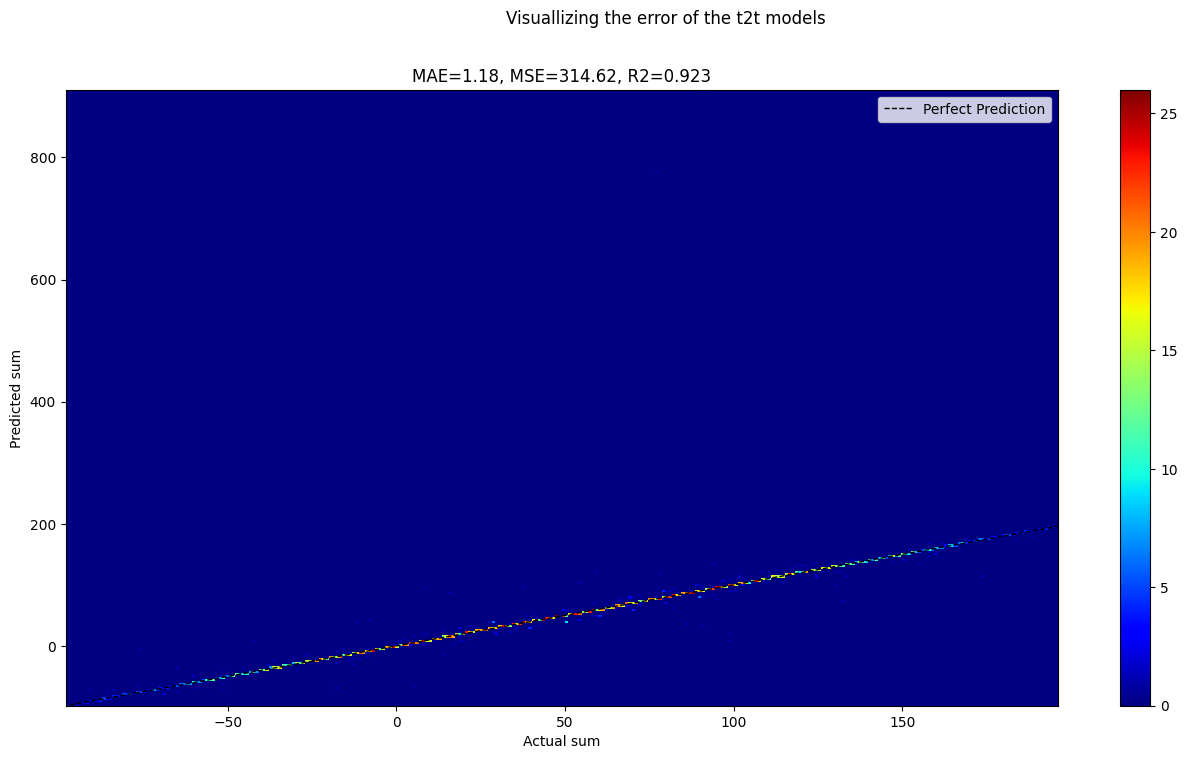

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


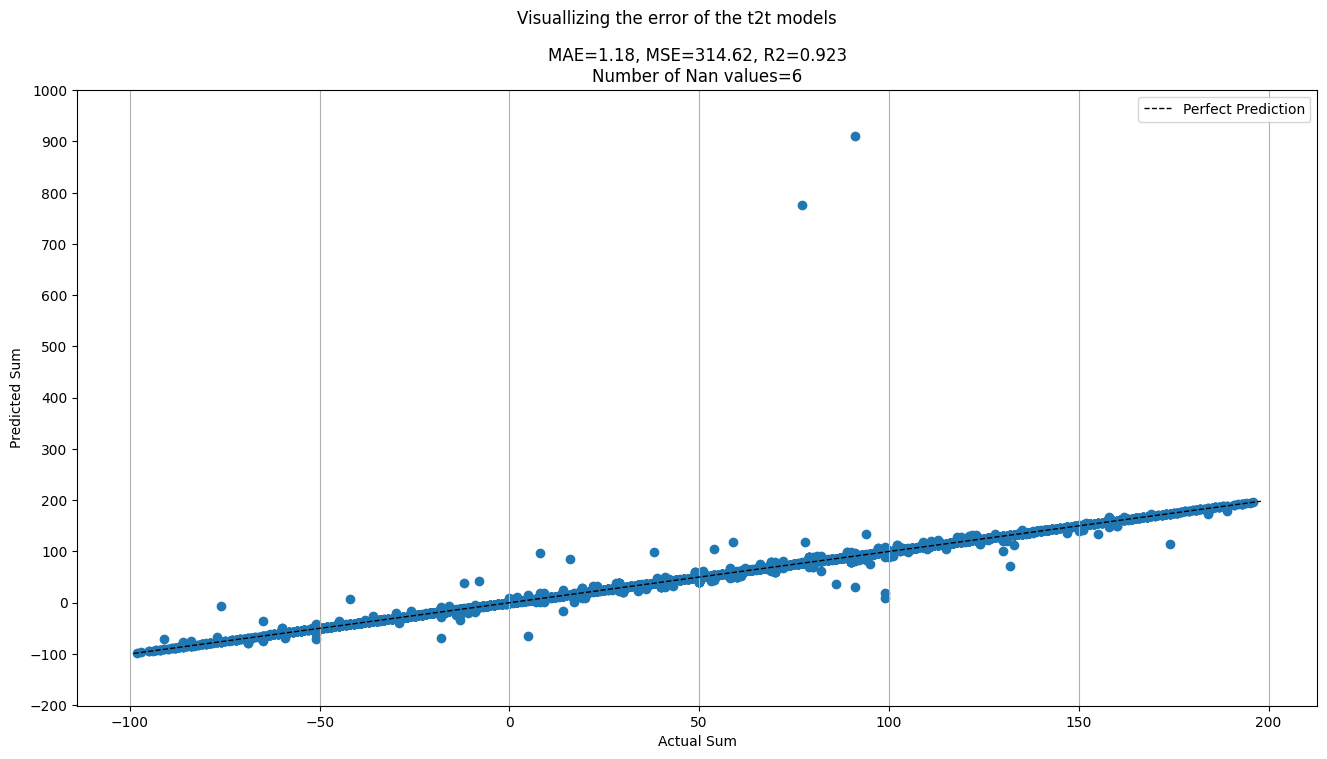

/tmp/ipykernel_31683/1712891088.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx].legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


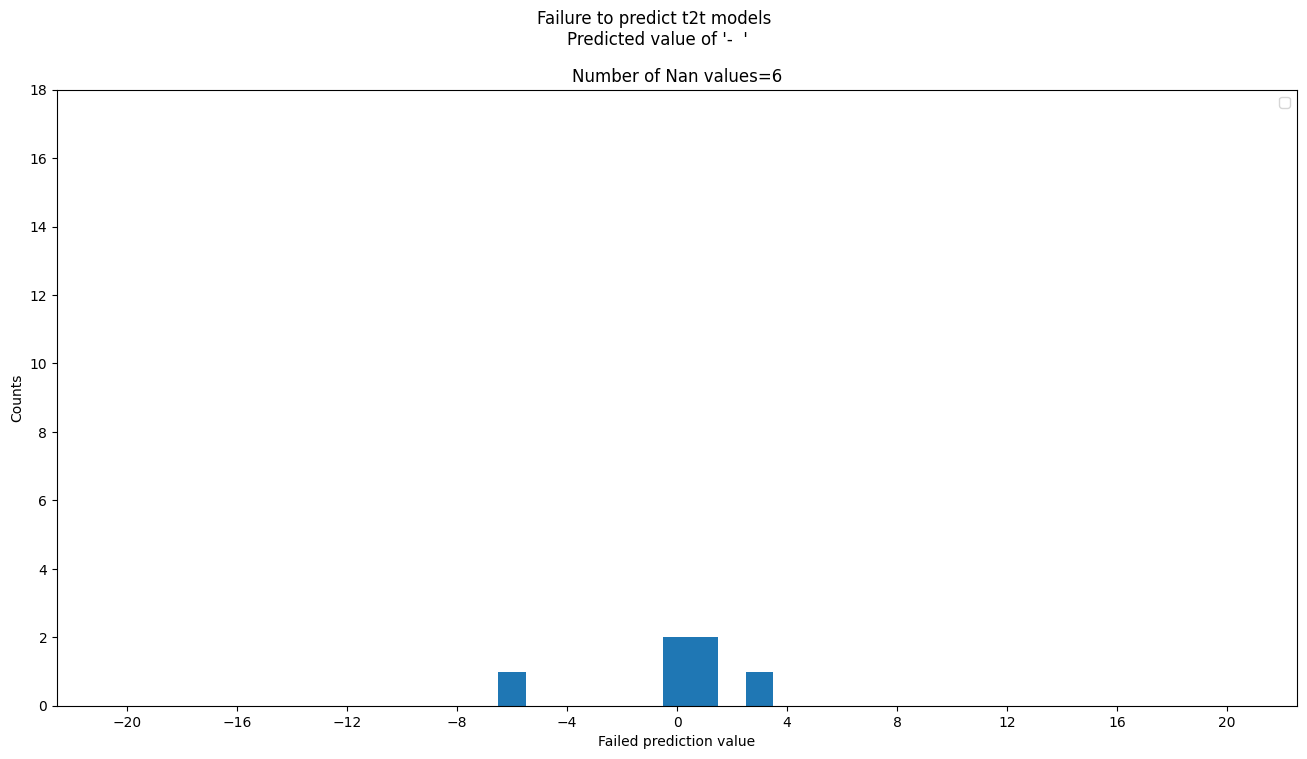

In [25]:
i2t_pred = model_img_to_text.predict(test_img_X)
i2t_data = {}
model_name = 'i2t_working'
i2t_data[model_name] = {'model': model_img_to_text,
                                                   'inputs': test_img_X,
                                                   'predictions': i2t_pred,
                                                   'true_values': test_text_y,
                                                   'history': history_model_img_to_text}

plot_hist_predictions(i2t_data)
plot_scatter_predictions(i2t_data)
# show_nan_table(i2t_data)
show_nan_hist(i2t_data)

In [11]:
import numpy as np

num_samples = 30
loss, acc = model_img_to_text.evaluate(test_img_X, test_text_y, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
preds = model_img_to_text.predict(test_img_X, verbose=0)

for i in range(num_samples):
    pred_idxs = np.argmax(preds[i], axis=-1)
    true_idxs = np.argmax(test_text_y[i], axis=-1)

    pred_text = ''.join(unique_characters[j] for j in pred_idxs)
    true_text = ''.join(unique_characters[j] for j in true_idxs)

    print(f"Sample {i}")
    print(f"  True: {true_text}")
    print(f"  Pred: {pred_text}")
    print('----------------------------------------')

Test Loss: 1.3275
Test Accuracy: 0.5374
Sample 0
  True: -7 
  Pred: -10
----------------------------------------
Sample 1
  True: -26
  Pred: -17
----------------------------------------
Sample 2
  True: -23
  Pred: -14
----------------------------------------
Sample 3
  True: 142
  Pred: 146
----------------------------------------
Sample 4
  True: 50 
  Pred: 40 
----------------------------------------
Sample 5
  True: -18
  Pred: -14
----------------------------------------
Sample 6
  True: 9  
  Pred: 11 
----------------------------------------
Sample 7
  True: 86 
  Pred: 89 
----------------------------------------
Sample 8
  True: 85 
  Pred: 99 
----------------------------------------
Sample 9
  True: 54 
  Pred: 55 
----------------------------------------
Sample 10
  True: 81 
  Pred: 50 
----------------------------------------
Sample 11
  True: -50
  Pred: -59
----------------------------------------
Sample 12
  True: -55
  Pred: -43
------------------------------------

## storing i2t model

In [12]:
stored_model = model_img_to_text

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
def build_text2img_model():


    model = tf.keras.Sequential()

    #ENCODER 
    #model.add(LSTM(256, input_shape=(max_query_length, len(unique_characters)), return_sequences=True))
  #  model.add(LSTM(256, input_shape=(max_query_length, len(unique_characters)), return_sequences=True))
    model.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))
    model.add(RepeatVector(3))   
   
   
   
    #Decoder    
    model.add(LSTM(256, return_sequences=True))  
 
    
    # Turn each 256 vector into a 7×7×64 shape for deconvolution
    model.add(TimeDistributed(Dense(7*7*64, activation='relu')))
    model.add(TimeDistributed(Reshape((7, 7, 64)))) 
    # Upsample 7 to 14 - reduce channels
    model.add(TimeDistributed(
        Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')
    ))  
    # Upsample 14 to 28
    model.add(TimeDistributed(
        Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')
    ))
    #final 1channel image
    model.add(TimeDistributed(
        Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')
    )) 

    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model


In [ ]:
X_train_text, X_test_text, y_train_img, y_test_img = train_test_split(
    X_text_onehot,      
    y_img,              
    train_size=0.7,
    random_state=67,
    shuffle=True
)

In [ ]:
model = build_text2img_model()

history = model.fit(
    X_train_text,        
    y_train_img,        
    epochs=20,
    batch_size=8,
    validation_data=(X_test_text, y_test_img)
)

In [ ]:
for i in range(30):
    
    idx = random.randint(0, len(X_test_text) - 1)
    x = X_test_text[idx:idx+1]
    y_pred = model.predict(x, verbose=0)[0]
    y_true = y_test_img[idx]
    query_str = decode_labels(x)[0]

    # Plot
    plt.figure(figsize=(10, 3))
    print(query_str)
    plt.subplot(1, 3, 2)
    plt.title("Predicted")
    plt.imshow(np.hstack([y_pred[j, :, :, 0] for j in range(3)]), cmap="gray")
    plt.axis("off")

 
    plt.show()